In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft

In [2]:
# 32.704s is when the recording starts, it takes eeg12['time'].iloc[0]s for the eeg to show up(which would be changed to 0.00s)
# 34.951s is when the first trial starts. So first_trial_start_time is the start time of the first trial in the eeg12 dataframe
# Note: this should only be run once or first_trial_start_time wouldn't be correct
first_trial_start_time = 34.951 - 32.704 - eeg_sig['time'].iloc[0]
eeg_sig['time'] = eeg_sig['time'] - eeg_sig['time'].iloc[0]

NameError: name 'eeg_sig' is not defined

In [ ]:
first_trial_start_time

In [ ]:
eeg_sig.head()

In [15]:
eeg_sig = eeg_sig.loc[eeg_sig['time'] > first_trial_start_time]

In [16]:
eeg12 = eeg12.drop(columns=eeg12.keys()[-1])
eeg12['time'] = eeg12['time'] - eeg12['time'].iloc[0]

In [17]:
eeg12

,time,Pz,F4,C4,P4,P3,C3,F3
286,0.000000,-12.341,-28.334408,-14.755320,-23.175016,-15.943630,-7.818284,-4.796939
287,0.003333,-8.729,-11.746624,-11.143320,-23.174354,-11.731192,-6.015370,3.039734
288,0.006667,-3.612,-23.528320,-10.251380,-18.057354,-5.113096,-3.008971,0.310911
289,0.010000,-2.107,-29.869143,-12.971439,-16.552354,-0.005466,0.003601,-3.615812
290,0.013333,7.525,-22.349480,-8.168079,-9.327914,4.823027,2.399255,-0.320823
...,...,...,...,...,...,...,...,...
42595,141.030000,-168.259,-222.274473,-154.376661,-184.810969,-185.371495,-93.784942,-129.633410
42596,141.033333,-164.346,-212.024462,-154.990511,-182.101748,-181.758714,-90.776485,-127.832747
42597,141.036667,-167.356,-224.087335,-154.982611,-179.092851,-185.969591,-92.881942,-129.333935
42598,141.040000,-156.219,-227.133169,-158.935110,-173.974748,-172.430837,-85.061601,-131.474482


In [18]:
eeg12 = eeg12.loc[eeg12['time']<129.999]

In [19]:
# every 1500 samples is a trial (5s at 300Hz)
eeg12.iloc[:1500]

,time,Pz,F4,C4,P4,P3,C3,F3
286,0.000000,-12.341,-28.334408,-14.755320,-23.175016,-15.943630,-7.818284,-4.796939
287,0.003333,-8.729,-11.746624,-11.143320,-23.174354,-11.731192,-6.015370,3.039734
288,0.006667,-3.612,-23.528320,-10.251380,-18.057354,-5.113096,-3.008971,0.310911
289,0.010000,-2.107,-29.869143,-12.971439,-16.552354,-0.005466,0.003601,-3.615812
290,0.013333,7.525,-22.349480,-8.168079,-9.327914,4.823027,2.399255,-0.320823
...,...,...,...,...,...,...,...,...
1781,4.983333,-44.849,-82.871065,-24.930861,-82.166166,-62.561933,-53.592918,-29.459117
1782,4.986667,-46.956,-87.392164,-24.925332,-82.768441,-68.271564,-59.921119,-21.909719
1783,4.990000,-49.063,-84.670966,-21.600112,-79.157489,-68.577249,-52.681173,-18.886758
1784,4.993333,-40.936,-84.088026,-17.396382,-72.535213,-61.651125,-49.679918,-19.209106


In [20]:
# MNE doesn't work with pandas dataframe so it should be converted into np array
time_array = eeg12['time']
eeg12 = eeg12.to_numpy()[:,1:].T # drop out the time (7,39000)
eeg12 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir') # bandpass filter

In [21]:
eeg12.shape

(7, 39000)

<AxesSubplot:xlabel='time', ylabel='vals'>

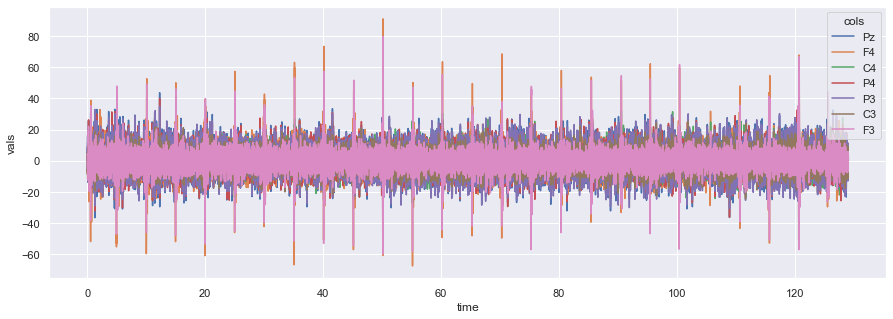

In [22]:
eeg12 = pd.DataFrame(eeg12.T, columns = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3'])
eeg12['time'] = time_array
eeg12_plot = eeg12.iloc[:, :].melt('time', var_name='cols',value_name='vals')
plt.figure(figsize=(15,5))
sns.lineplot(x='time',y='vals',hue='cols',data=eeg12_plot)

In [23]:
eeg12 = eeg12.drop(columns='time')
eeg12 = eeg12.to_numpy().T.reshape(7,26,1500).transpose(1,0,2) # back to numpy and epoch (26,7,1500)

In [24]:
eeg12.shape

(26, 7, 1500)

In [25]:
# FFT, Frequency-domain analysis
freqs = np.linspace(0.0, 300 / 2, 750)
psd12 = 2/750*np.abs(fft(eeg12)[:,:,:750])
psd12.shape,freqs.shape

((26, 7, 750), (750,))

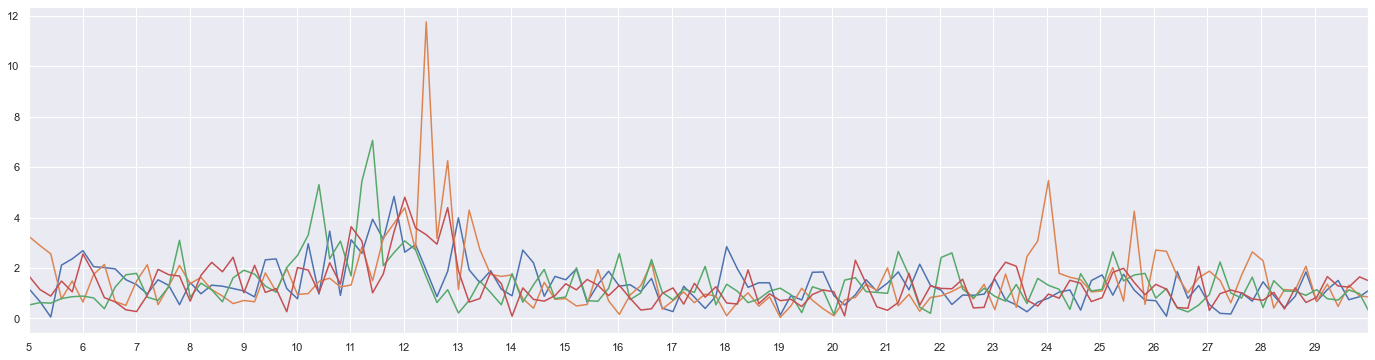

In [26]:
# R, B, U, X, E, D, A, G, P, M, W, J, F, V, N, C, L, Q, K, Z, O, I, Y, T, S, H
# 6, 1, 15, 5, 4, 12, 7, 25, 21, 11, 18, 16, 9, 14, 20, 8, 17, 0, 24, 23, 2, 13, 10, 3, 22, 19
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[6,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[1,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[15,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[5,0,:], ax=ax)
# sns.lineplot(x=freqs, y=psd12[4,0,:], ax=ax)
# sns.lineplot(x=freqs, y=psd12[5,0,:], ax=ax)
plt.xticks(range(5,30));
# for i in range(20,24):
#     sns.lineplot(x=freqs, y=psd12[i,0,:], ax=ax)

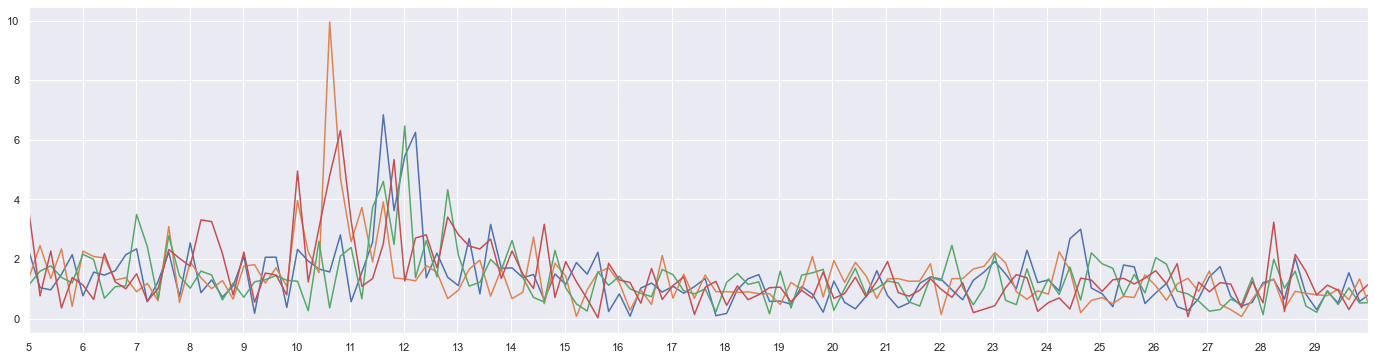

In [27]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[4,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[12,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[7,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[25,0,:], ax=ax)
plt.xticks(range(5,30));

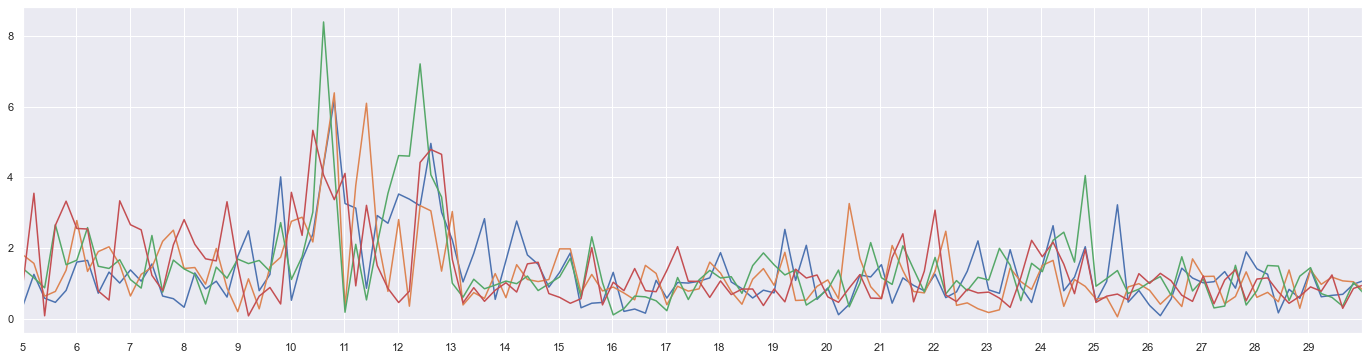

In [28]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[21,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[11,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[18,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[16,0,:], ax=ax)
plt.xticks(range(5,30));

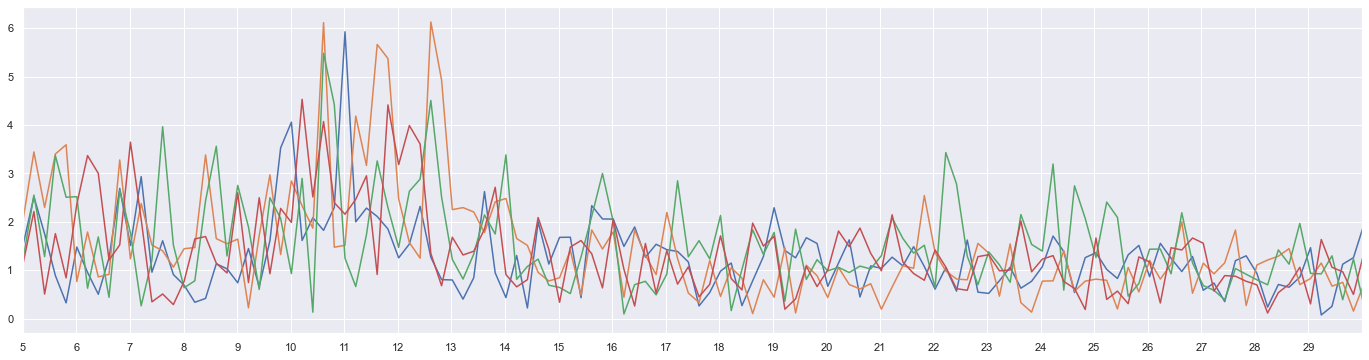

In [29]:
# 9, 14, 20, 8
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[9,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[14,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[20,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[8,0,:], ax=ax)
plt.xticks(range(5,30));

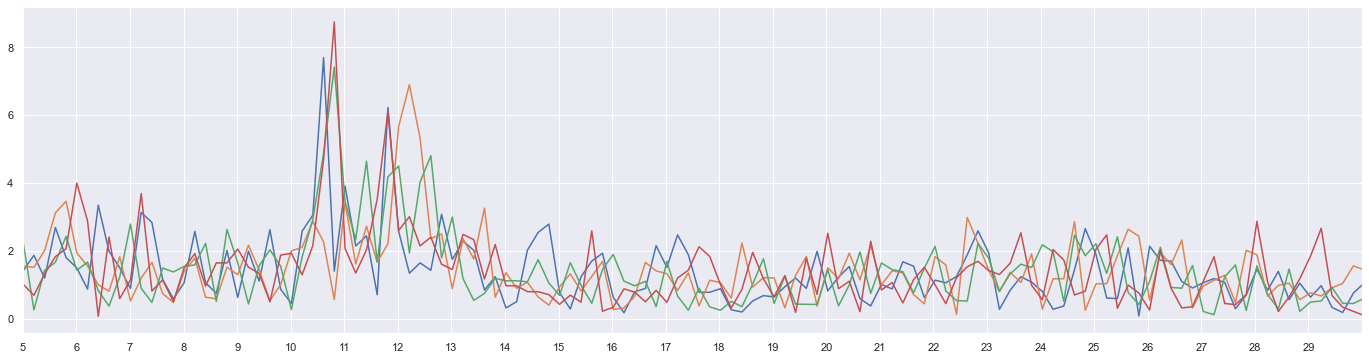

In [30]:
# 17, 0, 24, 23
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[17,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[0,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[24,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[23,0,:], ax=ax)
plt.xticks(range(5,30));

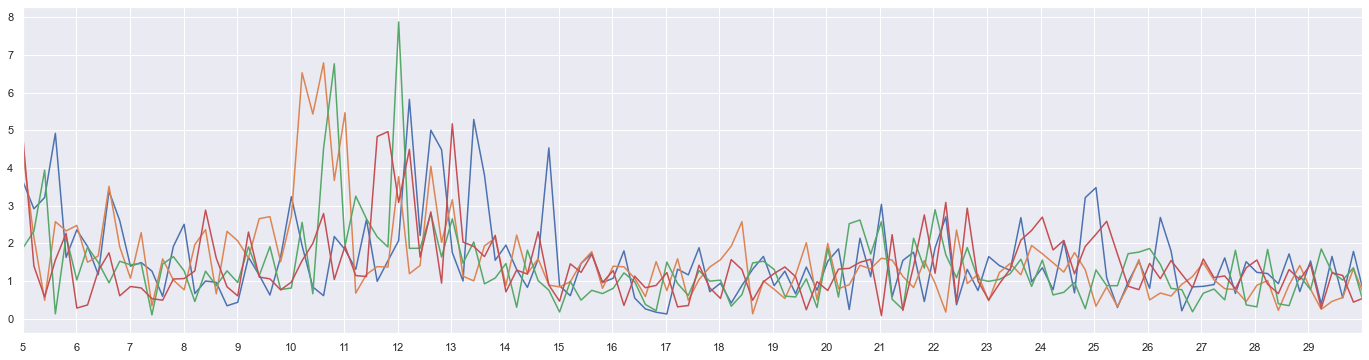

In [31]:
# 2, 13, 10, 3
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[2,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[13,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[10,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[3,0,:], ax=ax)
plt.xticks(range(5,30));

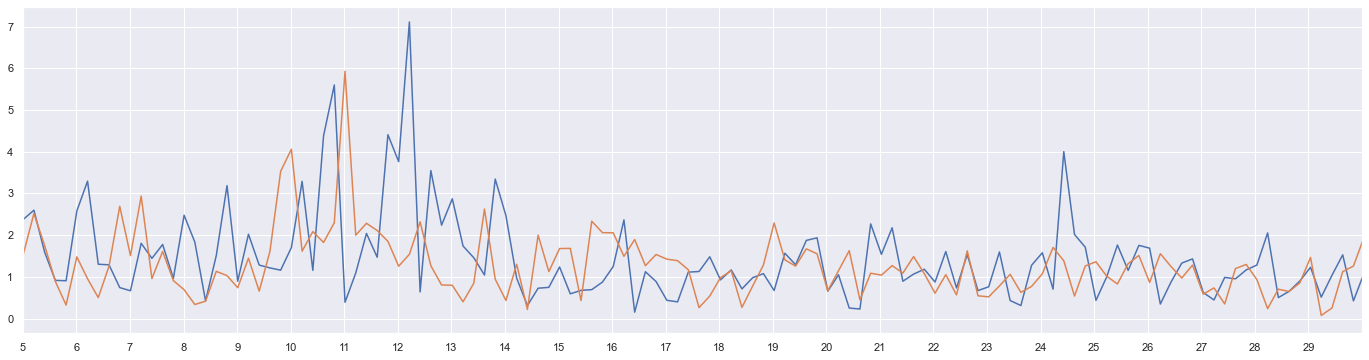

In [32]:
# 22, 19
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[22,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[9,0,:], ax=ax)
plt.xticks(range(5,30));

In [33]:
# R, B, U, X, E, D, A, G, P, M, W, J, F, V, N, C, L, Q, K, Z, O, I, Y, T, S, H
# 6, 1, 15, 5, 4, 12, 7, 25, 21, 11, 18, 16, 9, 14, 20, 8, 17, 0, 24, 23, 2, 13, 10, 3, 22, 19
eeg12.shape

(26, 7, 1500)

In [34]:
# eeg12[[6, 1, 15, 5, 4, 12, 7, 25, 21, 11, 18, 16, 9, 14, 20, 8, 17, 0, 24, 23, 2, 13, 10, 3, 22, 19],:,:][0,:,:]
# eeg12[6,:,:]
eeg12 = eeg12[[6,1,15,5,4,12,7,25,21,11,18,16,9,14,20,8,17,0,24,23,2,13,10,3,22,19],:,:]

In [35]:
eeg6 = pd.read_csv(data_path + 'pilot_eeg6.csv').astype(float)
eeg7 = pd.read_csv(data_path + 'pilot_eeg7.csv').astype(float)
eeg8 = pd.read_csv(data_path + 'pilot_eeg8.csv').astype(float)
eeg9 = pd.read_csv(data_path + 'pilot_eeg9.csv').astype(float)
eeg10 = pd.read_csv(data_path + 'pilot_eeg10.csv').astype(float)
eeg11 = pd.read_csv(data_path + 'pilot_eeg11.csv').astype(float)
first_trial_start_time6 = 22.362 - 19.501 - eeg6['time'].iloc[0]
first_trial_start_time7 = 26.741 - 24.396 - eeg7['time'].iloc[0]
first_trial_start_time8 = 42.854 - 40.238 - eeg8['time'].iloc[0]
first_trial_start_time9 = 43.639 - 40.769 - eeg9['time'].iloc[0]
first_trial_start_time10 = 38.800 - 35.688 - eeg10['time'].iloc[0]
first_trial_start_time11 = 42.738 - 40.502 - eeg11['time'].iloc[0]
eeg6 = eeg6.loc[eeg6['time']>first_trial_start_time6]
eeg7 = eeg7.loc[eeg7['time']>first_trial_start_time7]
eeg8 = eeg8.loc[eeg8['time']>first_trial_start_time8]
eeg9 = eeg9.loc[eeg9['time']>first_trial_start_time9]
eeg10 = eeg10.loc[eeg10['time']>first_trial_start_time10]
eeg11 = eeg11.loc[eeg11['time']>first_trial_start_time11]
eeg6['time'] = eeg6['time'] - eeg6['time'].iloc[0]
eeg7['time'] = eeg7['time'] - eeg7['time'].iloc[0]
eeg8['time'] = eeg8['time'] - eeg8['time'].iloc[0]
eeg9['time'] = eeg9['time'] - eeg9['time'].iloc[0]
eeg10['time'] = eeg10['time'] - eeg10['time'].iloc[0]
eeg11['time'] = eeg11['time'] - eeg11['time'].iloc[0]
eeg6 = eeg6.loc[eeg6['time']<129.999]
eeg7 = eeg7.loc[eeg7['time']<129.999]
eeg8 = eeg8.loc[eeg8['time']<129.999]
eeg9 = eeg9.loc[eeg9['time']<129.999]
eeg10 = eeg10.loc[eeg10['time']<129.999]
eeg11 = eeg11.loc[eeg11['time']<129.999]
eeg6 = eeg6.drop(columns=['time',' TRG'])
eeg7 = eeg7.drop(columns=['time',' TRG'])
eeg8 = eeg8.drop(columns=['time',' TRG'])
eeg9 = eeg9.drop(columns=['time',' TRG'])
eeg10 = eeg10.drop(columns=['time',' TRG'])
eeg11 = eeg11.drop(columns=['time',' TRG'])
eeg6 = eeg6.to_numpy().T
eeg7 = eeg7.to_numpy().T
eeg8 = eeg8.to_numpy().T
eeg9 = eeg9.to_numpy().T
eeg10 = eeg10.to_numpy().T
eeg11 = eeg11.to_numpy().T
eeg6 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg7 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg8 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg9 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg10 = mne.filter.filter_data(eeg10, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg11 = mne.filter.filter_data(eeg11, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg6 = eeg6.reshape(7,26,1500).transpose(1,0,2)
eeg7 = eeg7.reshape(7,26,1500).transpose(1,0,2)
eeg8 = eeg8.reshape(7,26,1500).transpose(1,0,2)
eeg9 = eeg9.reshape(7,26,1500).transpose(1,0,2)
eeg10 = eeg10.reshape(7,26,1500).transpose(1,0,2)
eeg11 = eeg11.reshape(7,26,1500).transpose(1,0,2)

In [36]:
with open(data_path + 'pilot_trials6.txt') as f:
    trials6 = f.read()
with open(data_path + 'pilot_trials7.txt') as f:
    trials7 = f.read()
with open(data_path + 'pilot_trials8.txt') as f:
    trials8 = f.read()
with open(data_path + 'pilot_trials9.txt') as f:
    trials9 = f.read()
with open(data_path + 'pilot_trials10.txt') as f:
    trials10 = f.read()
with open(data_path + 'pilot_trials11.txt') as f:
    trials11 = f.read()
trials6 = [char for char in trials6] # split the string into characters
trials6 = [ord(char) for char in trials6] # convert char to ascii decimal
trials6 = [ascii_val - ord('A') for ascii_val in trials6] # subtract each ascii decimal by that of 'A'
trials7 = [char for char in trials7] 
trials7 = [ord(char) for char in trials7] 
trials7 = [ascii_val - ord('A') for ascii_val in trials7] 
trials8 = [char for char in trials8] 
trials8 = [ord(char) for char in trials8] 
trials8 = [ascii_val - ord('A') for ascii_val in trials8] 
trials9 = [char for char in trials9] 
trials9 = [ord(char) for char in trials9] 
trials9 = [ascii_val - ord('A') for ascii_val in trials9] 
trials10 = [char for char in trials10] 
trials10 = [ord(char) for char in trials10] 
trials10 = [ascii_val - ord('A') for ascii_val in trials10] 
trials11 = [char for char in trials11] 
trials11 = [ord(char) for char in trials11] 
trials11 = [ascii_val - ord('A') for ascii_val in trials11] 

In [37]:
eeg6 = eeg6[trials6,:,:]
eeg7 = eeg7[trials7,:,:]
eeg8 = eeg8[trials8,:,:]
eeg9 = eeg9[trials9,:,:]
eeg10 = eeg10[trials10,:,:]
eeg11 = eeg11[trials11,:,:]

In [38]:
eeg6.shape,eeg7.shape,eeg8.shape,eeg9.shape,eeg10.shape,eeg11.shape,eeg12.shape

((26, 7, 1500),
 (26, 7, 1500),
 (26, 7, 1500),
 (26, 7, 1500),
 (26, 7, 1500),
 (26, 7, 1500),
 (26, 7, 1500))

In [39]:
eeg = np.array([eeg6,eeg7,eeg8,eeg9,eeg10,eeg11,eeg12])
eeg.shape

(7, 26, 7, 1500)

In [40]:
eeg = eeg[:,:,:,300:] # skip the first second
eeg.shape

(7, 26, 7, 1200)

In [41]:
freqs = np.linspace(0.0, 300 / 2, 600)
psd = 2/600*np.abs(fft(eeg)[:,:,:,:600])
psd.shape,freqs.shape

((7, 26, 7, 600), (600,))

In [42]:
psd = psd.mean(axis=0) # take the mean psd across sessions
psd.shape

(26, 7, 600)

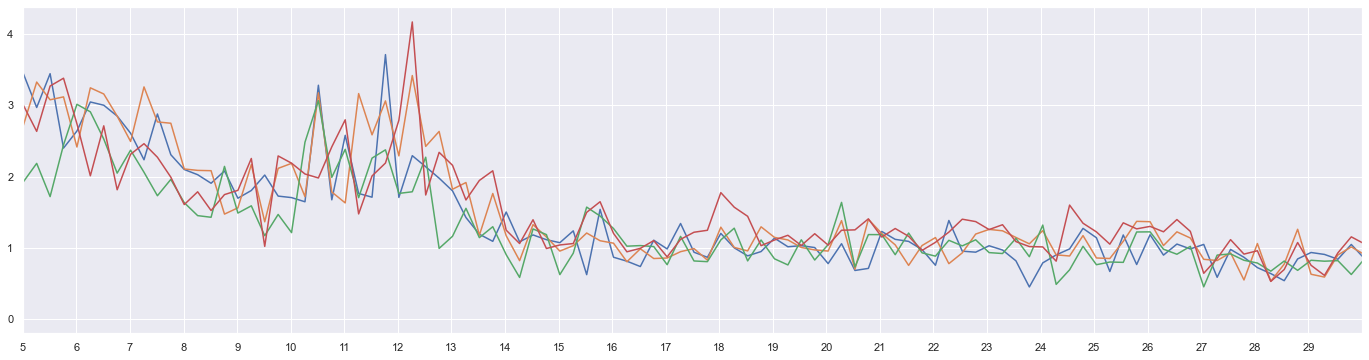

In [43]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[0,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[1,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[2,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[3,4,:], ax=ax)
plt.xticks(range(5,30));

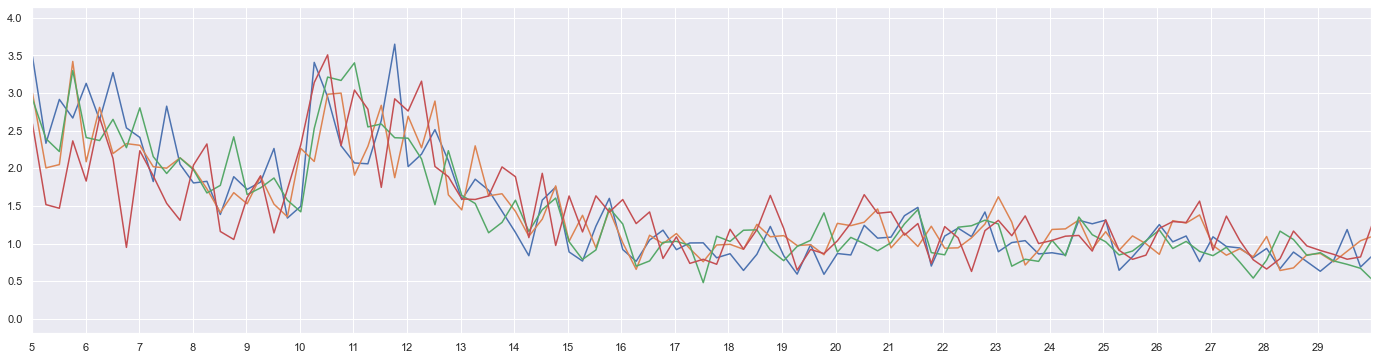

In [44]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[4,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[5,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[6,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[7,4,:], ax=ax)
plt.xticks(range(5,30));

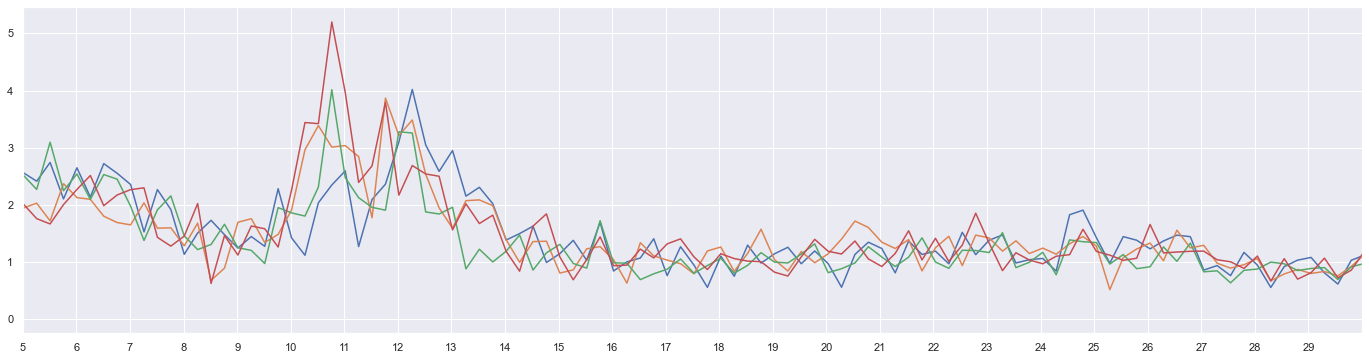

In [45]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[8,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[9,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[10,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[11,4,:], ax=ax)
plt.xticks(range(5,30));

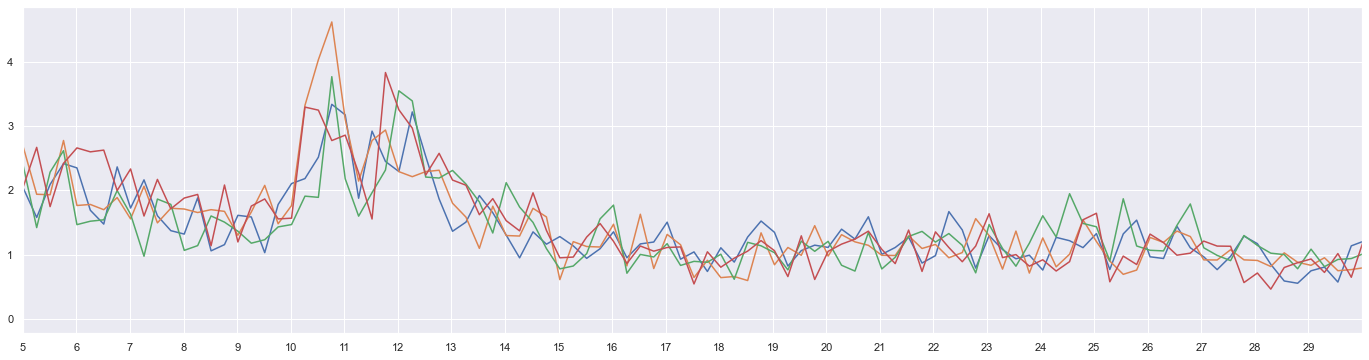

In [46]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[12,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[13,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[14,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[15,4,:], ax=ax)
plt.xticks(range(5,30));

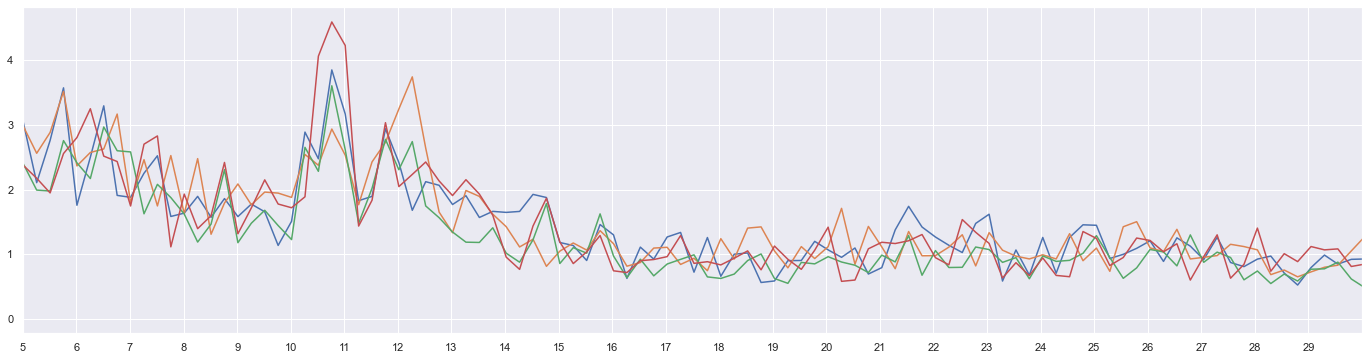

In [47]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[16,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[17,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[18,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[19,4,:], ax=ax)
plt.xticks(range(5,30));

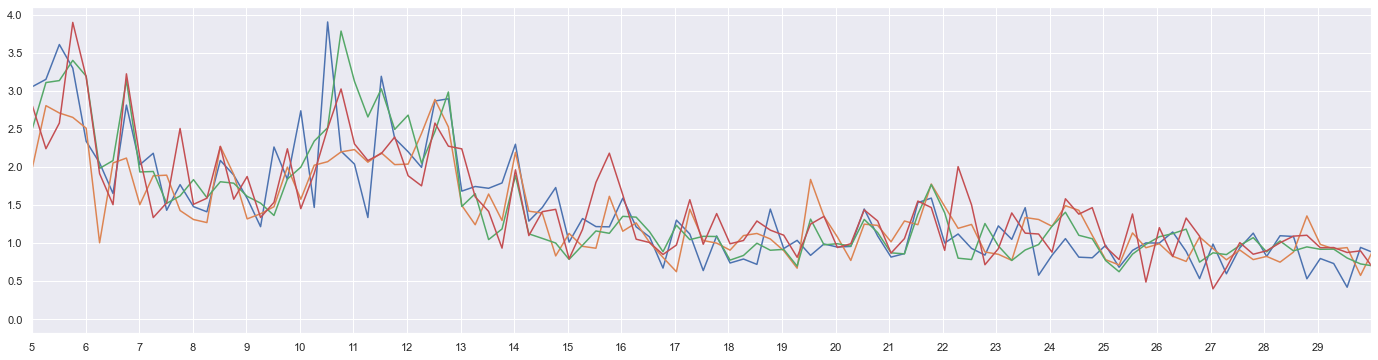

In [48]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[20,3,:], ax=ax)
sns.lineplot(x=freqs, y=psd[21,3,:], ax=ax)
sns.lineplot(x=freqs, y=psd[22,3,:], ax=ax)
sns.lineplot(x=freqs, y=psd[23,3,:], ax=ax)
plt.xticks(range(5,30));

In [49]:
montage = mne.channels.make_standard_montage('standard_1020')
channels = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3']
info = mne.create_info(ch_names=channels, sfreq=300, ch_types=['eeg'] * 7)

## Data Using PsychoPy

### 5s x 20 trials Average

In [28]:
data_path = "../data/eeg_recordings/simon/"
filename = 'eeg.csv'
metaname = 'meta.csv'
sampling_frequency = 300
isi_duration = 0.750  # s
stimulus_duration = 5.000 # s
num_trial_per_target = 20
channels = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3']
num_channels = len(channels)

eeg = pd.read_csv(data_path + filename).astype(float)
meta = np.loadtxt(data_path + metaname, delimiter=',', dtype=float)
trials = meta[1:,0]
times = meta[:,1]
times = (times - times[0])[1:]
num_targets = len(np.unique(trials))
freq_tab = {freq:index for index, freq in enumerate(np.unique(trials))}
num_trials = num_targets * num_trial_per_target

timepoints_stimulus_duration = int(stimulus_duration * sampling_frequency)
timepoints_isi = int(sampling_frequency * isi_duration)
timepoints_per_trial = int((isi_duration + stimulus_duration) * sampling_frequency)
timepoints_all_trials = int((isi_duration + stimulus_duration) * sampling_frequency * num_trials)

print("Num targets:", num_targets)
print("Targets:", freq_tab.keys())

Num targets: 40
Targets: dict_keys([8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.6, 12.8, 13.0, 13.2, 13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14.8, 15.0, 15.2, 15.4, 15.6, 15.8])


In [29]:
# trial aligned to the first data point
eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
eeg = eeg.loc[eeg['time'] > times[0]]
eeg = eeg.drop(columns=['time',' TRG'])

# trializing the data, not interested in isi session
eeg = eeg.to_numpy().T[:,:timepoints_all_trials].reshape(num_channels, num_trials, timepoints_per_trial).transpose(1,0,2)[:,:,timepoints_isi:]
eeg = mne.filter.filter_data(eeg, sfreq=sampling_frequency, l_freq=5, h_freq=49, verbose=0, method='fir')

In [30]:
eeg_by_freq = []
for i in range(num_targets):
    eeg_by_freq.append([])
for i,freq in enumerate(trials):
    eeg_by_freq[freq_tab[freq]].append(eeg[i])
eeg_by_freq = np.array(eeg_by_freq).transpose(1,0,2,3)  
freqs = np.linspace(0.0, sampling_frequency / 2, timepoints_stimulus_duration // 2)
psd = 2/(timepoints_stimulus_duration / 2)*np.abs(fft(eeg_by_freq)[:,:,:,:timepoints_stimulus_duration // 2])
psd = psd.mean(axis=0) # take the mean psd across sessions

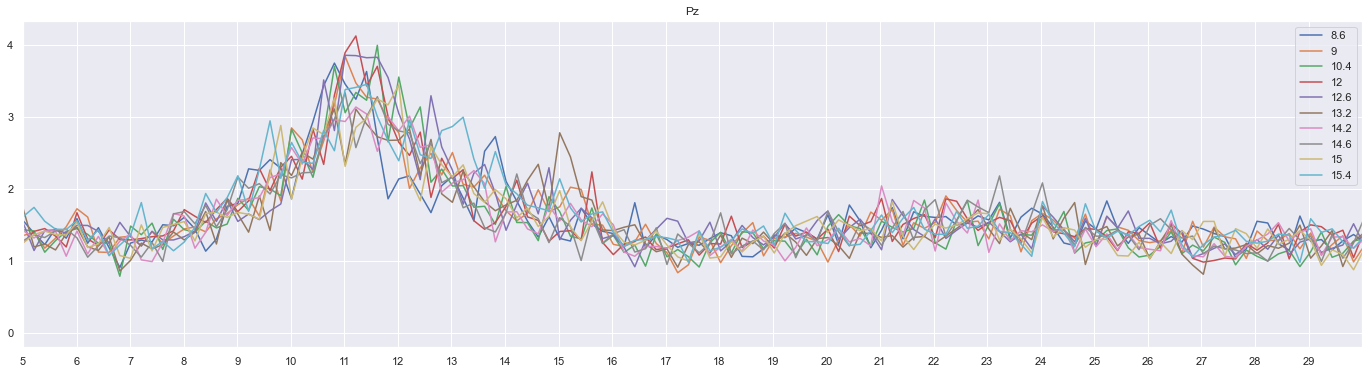

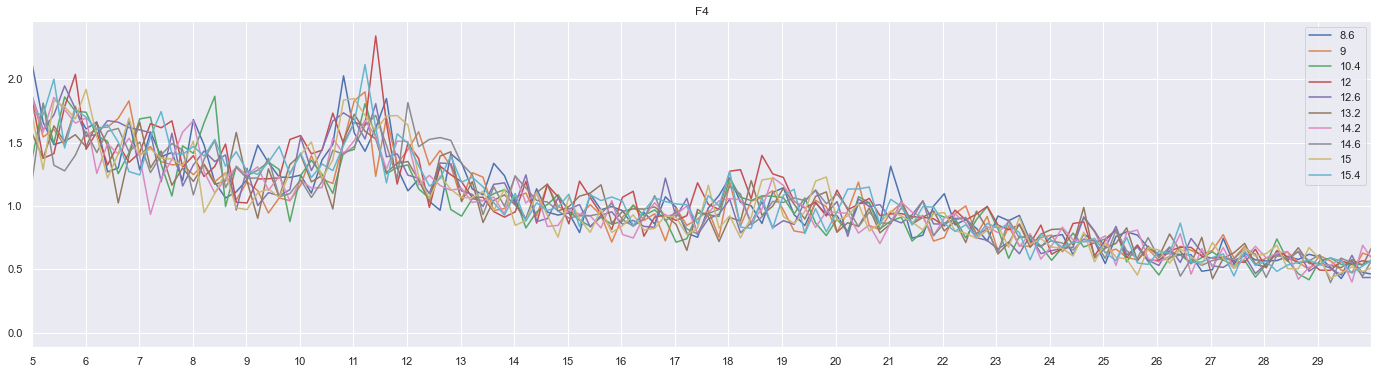

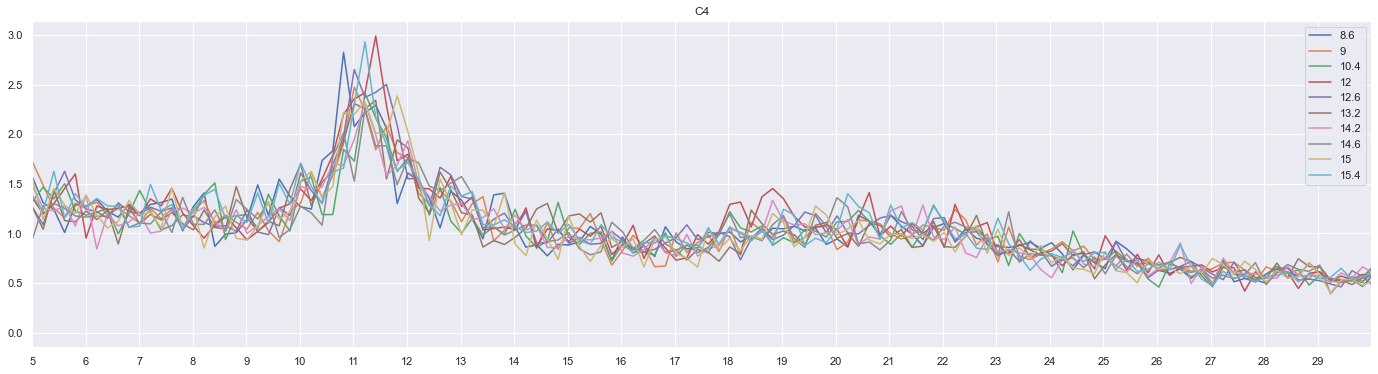

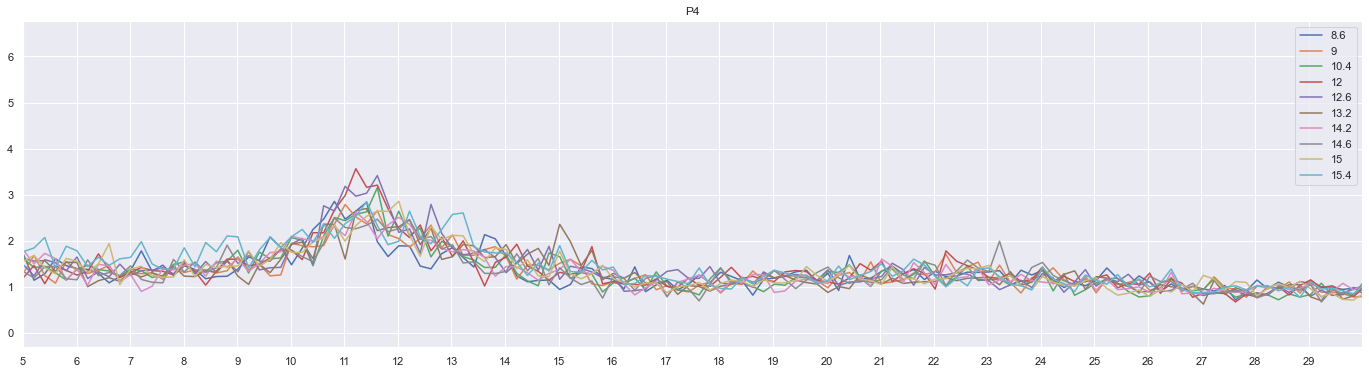

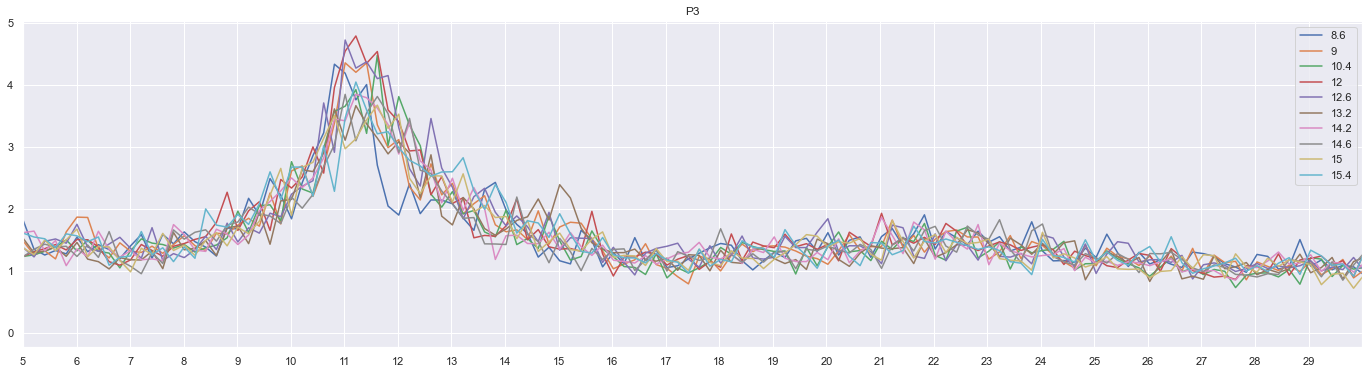

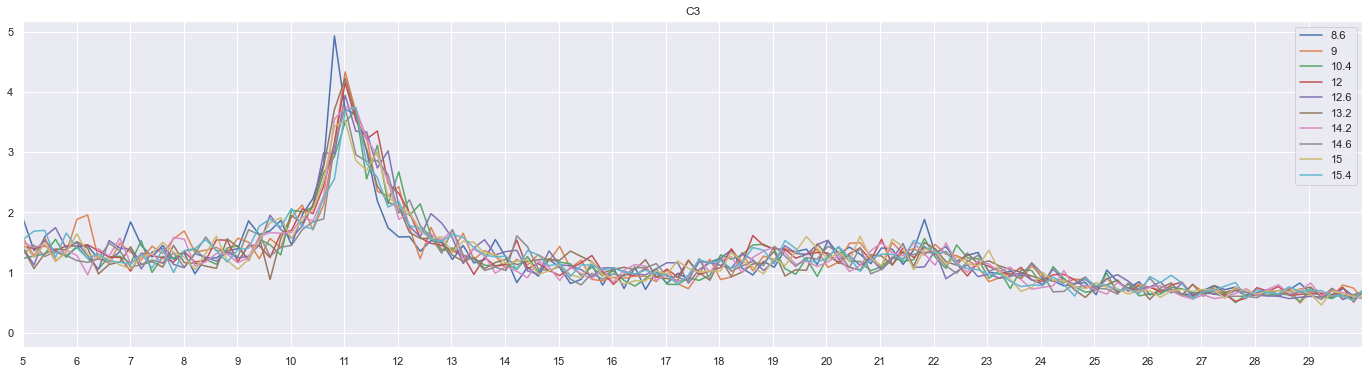

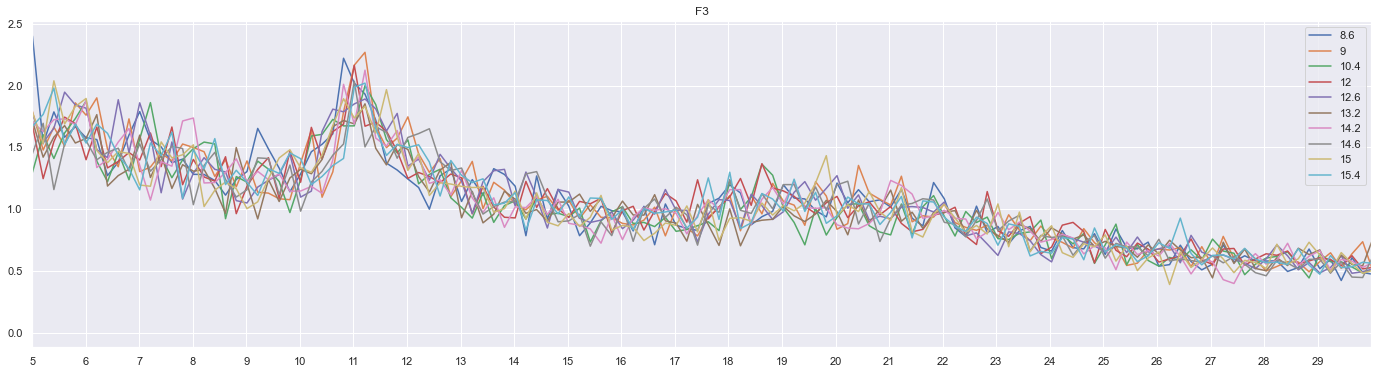

In [38]:
# Visualize some of the targets on frequency domain
target_interest = [8.6, 9, 10.4, 12, 12.6, 13.2, 14.2, 14.6, 15, 15.4]
channel_interest = channels
for channel in channel_interest:
    plt.figure(figsize=(24, 6))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    for freq in target_interest:
        sns.lineplot(x=freqs, y=psd[list(freq_tab.keys()).index(freq), channels.index(channel),:], ax=ax, label=freq)
    plt.title(channel)
    plt.xticks(range(5,30));

In [39]:
# target_interest = list(freq_tab.keys())
# plt.figure(figsize=(24, 6))
# ax = plt.subplot()
# ax.set_xlim(5, 30)
# for freq in target_interest:
#     sns.lineplot(x=freqs, y=psd[list(freq_tab.keys()).index(freq),3,:], ax=ax, label=freq)
# plt.xticks(range(5,30));